In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import math

### Data

* Join the tables for W01 and W02. 
* Select features from file and add colors. 
* Check number of members vs non members.
* Split into training, validation and testing samples.

In [2]:
df1 = pd.read_csv('../../DATA/clean-HSC-unWISE-W01.csv')
df2 = pd.read_csv('../../DATA/clean-HSC-unWISE-W02.csv')
df = pd.concat([df1,df2], axis = 'rows')
del df1,df2

with open('../../DATA/features1.txt') as file:
    features = file.read().splitlines()
labels = 'member'

n_mem = df[df.member == 1].shape[0]
n_no = df[df.member == 0].shape[0]
n = df.shape[0]
print ('Members: {} ({:.2f}%)'.format(n_mem, n_mem/n*100))
print ('Non members: {} ({:.2f}%)'.format(n_no, n_no/n*100))
del n,n_mem,n_no

Members: 40238 (32.60%)
Non members: 83198 (67.40%)


In [3]:
df_cl = pd.read_table('../../DATA/clusters.dat', delim_whitespace=True, usecols=[0,3,4,5,9,11,12], names=['id_cl','ra_cl','dec_cl','phot_z_cl', 'r500_cl','mass_cl','n500_cl'])
df = df.reset_index(drop=True)

# evaluate the nearest clusters' ids columns
df['id_cl_near'] = [np.array(eval(s)) for s in df.id_cl_near]
df['z_cl_near'] = -99

# add a column with the z of the first cluster in the list of id_cl_near
col_i = df.columns.get_loc('z_cl_near')
for i,row in df.iterrows():
    if row.member == 0:
        df.iloc[i,col_i] = df_cl[df_cl.id_cl == row.id_cl_near[0]]['phot_z_cl'].values[0]
    else:
        df.iloc[i,col_i] = df_cl[df_cl.id_cl == row.id_cl]['phot_z_cl'].values[0]

In [14]:
features.append('z_cl_near')

from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size = 0.3, stratify = df[labels])
val, test = train_test_split(test, test_size = 0.3, stratify = test[labels])
print ('Training: {} members, {} non members'.format(train[train.member == 1].shape[0], train[train.member == 0].shape[0]))
print ('Validation: {} members, {} non members'.format(val[val.member == 1].shape[0], val[val.member == 0].shape[0]))
print ('Testing: {} members, {} non members'.format(test[test.member == 1].shape[0], test[test.member == 0].shape[0]))

Training: 28167 members, 58238 non members
Validation: 8449 members, 17472 non members
Testing: 3622 members, 7488 non members


### Model

In [15]:
callbacks = [
    # tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    tf.keras.callbacks.CSVLogger(filename = 'history_5.csv'),
    tf.keras.callbacks.ModelCheckpoint(filepath = 'model_5.h5', monitor = 'val_loss',  save_best_only = True),
    # tf.keras.callbacks.TensorBoard()
]

norm = tf.keras.layers.Normalization(input_shape=(len(features),))
norm.adapt(data = train[features]) 

In [16]:
from sklearn.utils.class_weight import compute_class_weight
wei =  compute_class_weight(class_weight = 'balanced', classes = np.unique(df[labels]), y = df[labels])
weights = {}
for w,l in zip(wei,np.unique(df[labels])):
    weights[l] = w

del wei
print (weights)

{0: 0.741820716844155, 1: 1.5338237486952633}


In [17]:
model = tf.keras.Sequential([
    norm,
    tf.keras.layers.Dense(64, activation=tf.keras.activations.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation=tf.keras.activations.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics=[]
)
# tf.keras.metrics.BinaryAccuracy(name = 'accuracy'), tf.keras.metrics.Precision(name = 'precision'), tf.keras.metrics.Recall(name = 'recall')

In [18]:
model.fit(
    x = train[features].values, 
    y = train[labels].values,
    verbose = 1, 
    callbacks = callbacks,
    validation_data = (val[features].values, val[labels].values), 
    epochs = 60,
    batch_size = 4096,
    class_weight = weights
)  

Epoch 1/60
22/22 [==============================] - 1s 31ms/step - loss: 0.6919 - val_loss: 0.6103
Epoch 2/60
22/22 [==============================] - 0s 18ms/step - loss: 0.6150 - val_loss: 0.5667
Epoch 3/60
22/22 [==============================] - 0s 20ms/step - loss: 0.5731 - val_loss: 0.5224
Epoch 4/60
22/22 [==============================] - 0s 18ms/step - loss: 0.5308 - val_loss: 0.4755
Epoch 5/60
22/22 [==============================] - 0s 22ms/step - loss: 0.4854 - val_loss: 0.4374
Epoch 6/60
22/22 [==============================] - 0s 18ms/step - loss: 0.4442 - val_loss: 0.3943
Epoch 7/60
22/22 [==============================] - 1s 23ms/step - loss: 0.4059 - val_loss: 0.3620
Epoch 8/60
22/22 [==============================] - 0s 17ms/step - loss: 0.3742 - val_loss: 0.3267
Epoch 9/60
22/22 [==============================] - 0s 18ms/step - loss: 0.3486 - val_loss: 0.3118
Epoch 10/60
22/22 [==============================] - 0s 18ms/step - loss: 0.3333 - val_loss: 0.3087
Epoch 11/

In [19]:
# load best model and training history
model = tf.keras.models.load_model('model_5.h5')
history = pd.read_csv('history_5.csv')

### Tests

* Training and validation loss plot
* Confusion matrix plot
* ROC curve plot
* Loss on test sample
* ROC & precision-recall AUC 
* Precision, recall, F1...


In [20]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, classification_report

pred = model.predict(test[features], verbose = 0)
pred_classes = np.round(pred, decimals = 0)

test_loss = model.evaluate(test[features], test[labels], verbose=0)
fpr, tpr, thresholds_roc = roc_curve(test[labels], pred, pos_label=1)
precision, recall, thresholds_pr = precision_recall_curve(test[labels], pred, pos_label= 1)

# def model_write(string):
#     file.write(string + '\n')

# with open('report.txt', mode='x') as file:
#     model.summary(print_fn= model_write)
#     file.write('\n\n')
#     file.write('Optimizer: {} \n'.format(model.optimizer))
#     file.write('Loss function: {} \n'.format(model.loss))
#     file.write('Notes: \n')
#     file.write('-'*70 + '\n')
#     file.write('Loss on test dataset: {:.4g} \n'.format(test_loss))
#     file.write('AUC: {}\n'.format(auc(fpr, tpr)))
#     file.write('-'*70 + '\n')
#     file.write(classification_report(test[labels],pred_classes))

print('Loss on test dataset: {:.4g} \n'.format(test_loss))
print('ROC AUC: {}\n'.format(auc(fpr, tpr)))
print('Precision-recall AUC: {}\n'.format(auc(recall, precision)))
print('-'*70 + '\n')
print(classification_report(test[labels],pred_classes))

Loss on test dataset: 0.2241 

ROC AUC: 0.9709029754067026

Precision-recall AUC: 0.9306270322829795

----------------------------------------------------------------------

              precision    recall  f1-score   support

           0       0.97      0.87      0.92      7488
           1       0.78      0.95      0.86      3622

    accuracy                           0.90     11110
   macro avg       0.88      0.91      0.89     11110
weighted avg       0.91      0.90      0.90     11110



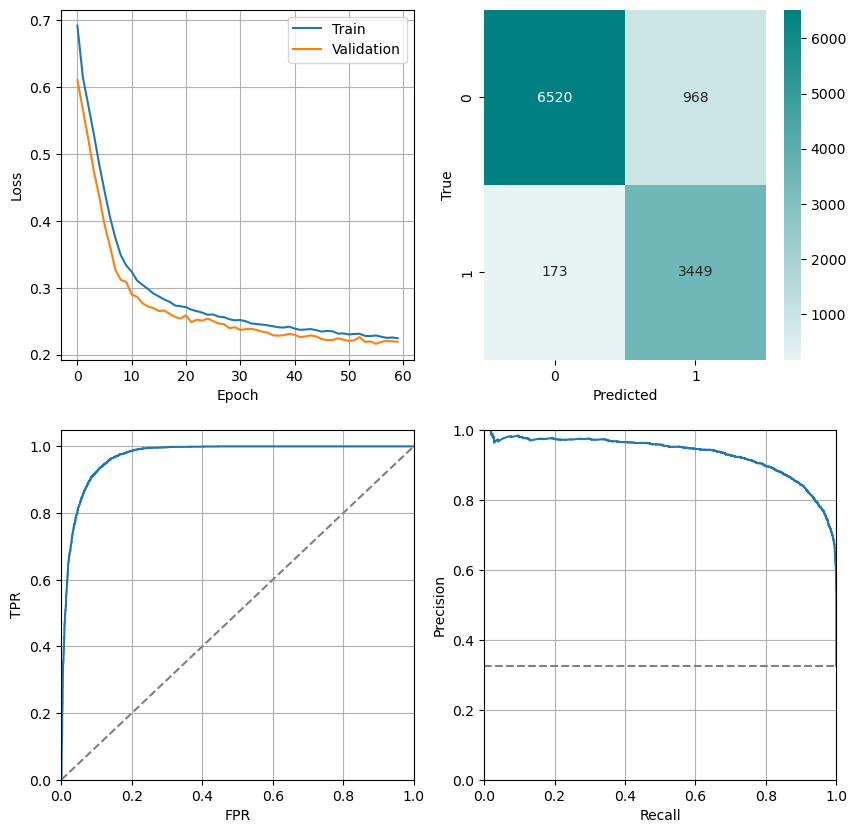

In [21]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(10,10))

# Loss during training
plt.subplot(2, 2, 1)
plt.plot(history['loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend()

# Confusion matrix
plt.subplot(2, 2, 2)
conf_m = confusion_matrix(test[labels], pred_classes)
df_conf_m = pd.DataFrame(conf_m, index=[0,1], columns=[0,1])
sns.heatmap(df_conf_m, cmap=sns.color_palette('light:teal', as_cmap=True), annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')

# ROC Curve
plt.subplot(2, 2, 3)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()

# Precision-recall curve
plt.subplot(2, 2, 4)
plt.plot(recall, precision)
plt.plot([0, 1], [len (test[test.member == 1])/len(test), len (test[test.member == 1])/len(test)] , color='gray', linestyle='--')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.xlim([0,1])
plt.ylim([0,1])

# plt.savefig('fig.png', dpi=150, bbox_inches= 'tight')
plt.show()

### Perfomance vs Features

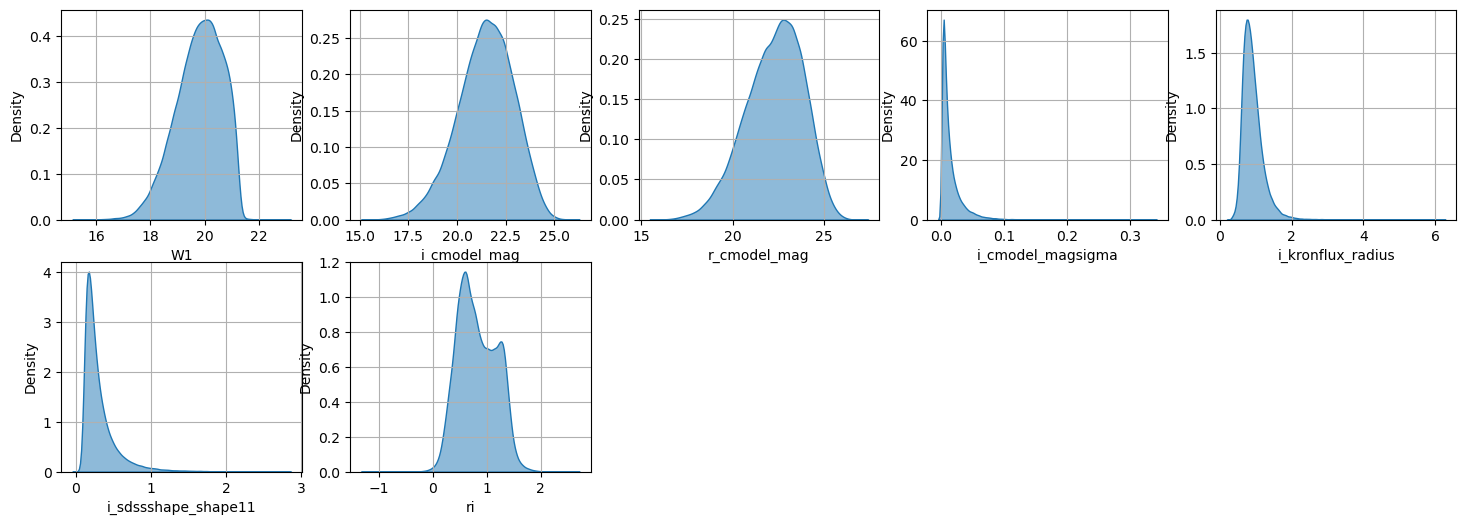

In [22]:
feat_test = ['W1', 'i_cmodel_mag', 'r_cmodel_mag', 'i_cmodel_magsigma', 'i_kronflux_radius', 'i_sdssshape_shape11', 'ri']

# check distributions...
plt.figure(figsize=(18, 3*math.ceil(len(feat_test)/5)))
for i,f in enumerate(feat_test):
    plt.subplot(math.ceil(len(feat_test)/5), 5, i+1)
    sns.kdeplot(df[f], fill = True, alpha = 0.5)
    plt.grid()
plt.show()
plt.close()

In [23]:
def cut_tests(f, feat_cuts, color):
    feat_cond = []
    for i in range(len(feat_cuts) - 1):
        feat_cond.append(
            (test[f] >= feat_cuts[i]) & (test[f] <= feat_cuts[i+1])
        )

    plt.figure(figsize=(18,4*math.ceil(len(feat_test)/4)))
    for i,c in enumerate(feat_cond):
        # Confusion matrix
        plt.subplot(math.ceil(len(feat_test)/4), 4, i+1)
        conf_m = confusion_matrix(test[c][labels], pred_classes[c])
        df_conf_m = pd.DataFrame(conf_m, index=[0,1], columns=[0,1])
        sns.heatmap(df_conf_m, cmap=sns.color_palette(f'light:{color}', as_cmap=True), annot=True, fmt='d')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'{f} in ({feat_cuts[i]}, {feat_cuts[i+1]})')

    plt.figure(figsize=(18,4*math.ceil(len(feat_test)/4)))
    for i,c in enumerate(feat_cond):
        # ROC Curve
        plt.subplot(math.ceil(len(feat_test)/4), 4, i+1)
        plt.title(f'{f} in ({feat_cuts[i]}, {feat_cuts[i+1]})')
        fpr_1, tpr_1, _ = roc_curve(test[c][labels], pred[c], pos_label=1)
        plt.plot(fpr_1, tpr_1, c = color)
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.grid()

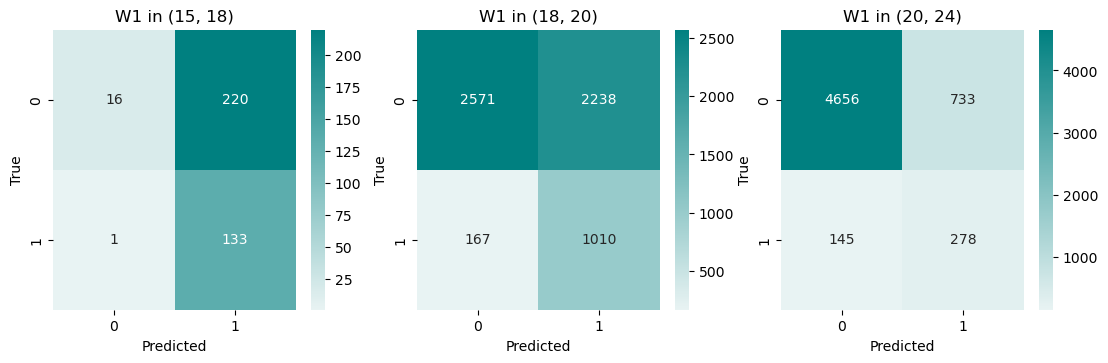

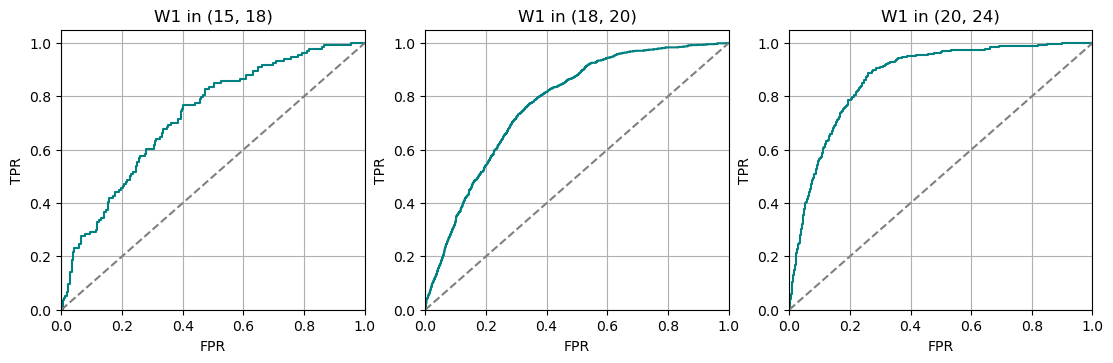

In [57]:
cut_tests('W1', feat_cuts = [15,18,20,24], color = 'teal')    

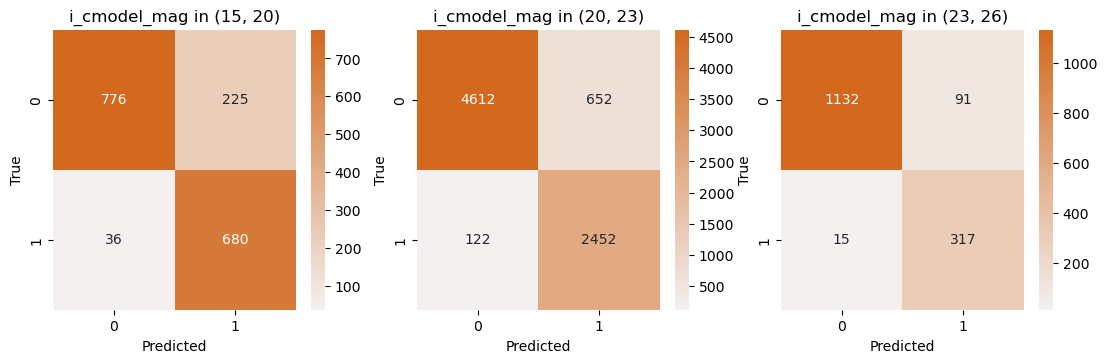

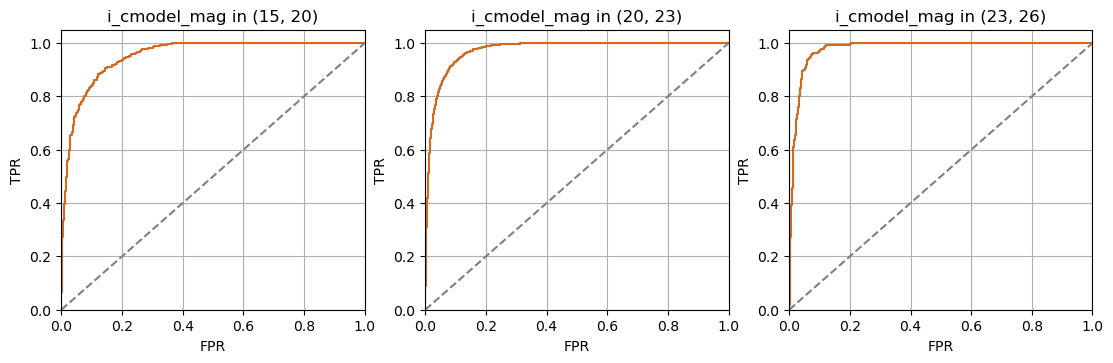

In [24]:
cut_tests('i_cmodel_mag', feat_cuts = [15,20,23,26], color = 'chocolate')    

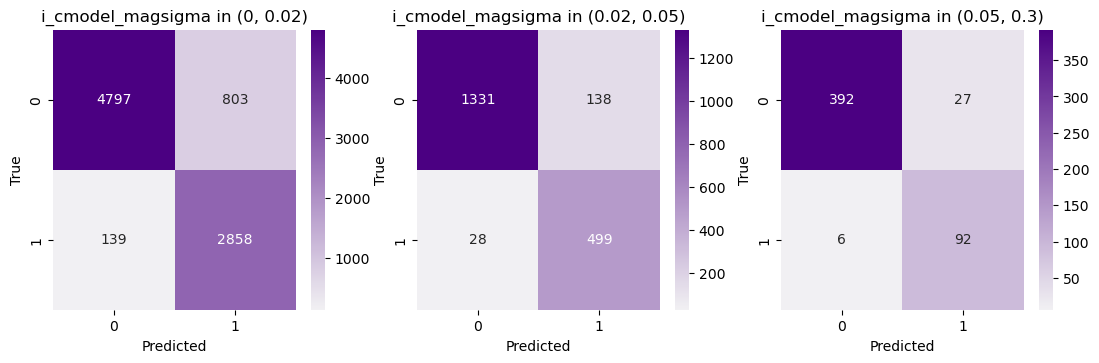

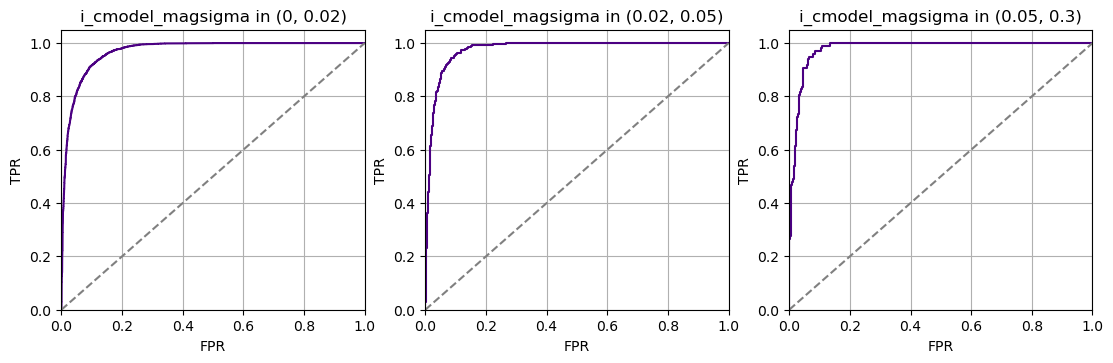

In [25]:
cut_tests('i_cmodel_magsigma', feat_cuts = [0,0.02,0.05,0.3], color = 'indigo')    

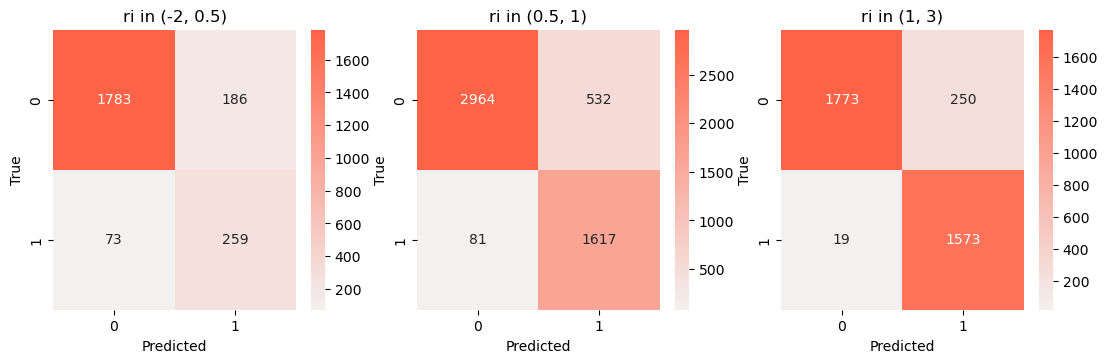

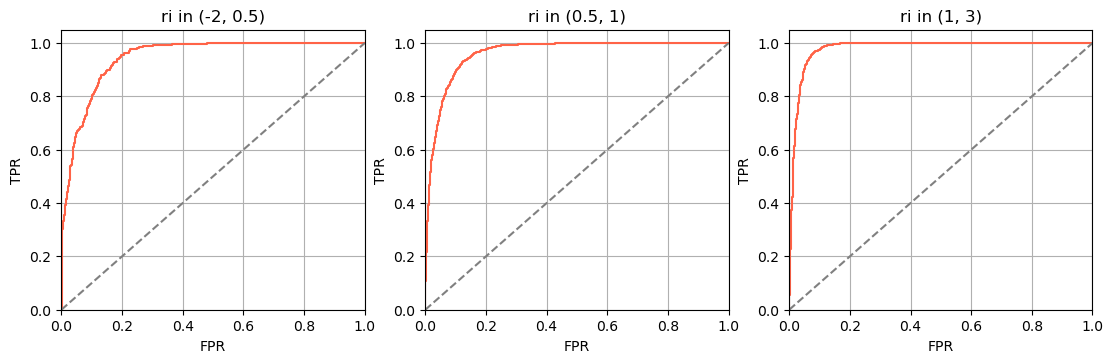

In [26]:
cut_tests('ri', feat_cuts = [-2,0.5,1,3], color = 'tomato')    